In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# -*- coding: utf-8 -*-
"""
Part 1: Training Script for U-Net Coastline Segmentation
Handles setup, data loading, normalization adaptation, model building,
compilation, and training. Saves the best model.

All refrences to the code have been taken from 'http://github.com/aladdinpersson'
"""

# --- Imports ---
import tensorflow as tf
import numpy as np
import random
import os
import glob
from tqdm.notebook import tqdm # Use notebook version for Kaggle
import rasterio # For reading .jp2 files
import math
import warnings

warnings.filterwarnings('ignore')

# --- 1. Setup & Configuration ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- Dataset Paths (Kaggle specific) ---
BASE_DATA_PATH = '/kaggle/input/sentinel-2-wasirq/Data-Set-Unet/'
TRAIN_PATH = os.path.join(BASE_DATA_PATH, 'train/')
VAL_PATH = os.path.join(BASE_DATA_PATH, 'val/')
# TEST_PATH is not strictly needed for training, but defined for consistency
TEST_PATH = os.path.join(BASE_DATA_PATH, 'test/')

# --- Image Dimensions ---
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 12

# --- Training Configuration ---
BATCH_SIZE = 8
BUFFER_SIZE = 1000 # For shuffling tf.data.Dataset
EPOCHS = 50
# Number of batches from training set to use for adapt()
NUM_ADAPT_BATCHES = 500 # Adjust based on dataset size & desired accuracy for stats

# --- Model Checkpoint Path (Kaggle output directory) ---
MODEL_CHECKPOINT_PATH = '/kaggle/working/coastline_unet_model_s2_256_adapt.keras'
TENSORBOARD_LOG_DIR = '/kaggle/working/logs_coastline_s2_256_adapt'

# --- Optional: Pre-trained Weights ---
PRETRAINED_WEIGHTS_PATH = None

# --- 2. Data Loading & Preprocessing Functions for tf.data ---

def get_file_paths(data_dir):
    """Gets sorted lists of image and mask file paths."""
    images_path = os.path.join(data_dir, 'images/')
    masks_path = os.path.join(data_dir, 'masks/')
    image_files = sorted(glob.glob(os.path.join(images_path, '*.jp2')))
    mask_files = sorted(glob.glob(os.path.join(masks_path, '*.png')))

    if len(image_files) != len(mask_files):
        print(f"Warning: Mismatch! Found {len(image_files)} images and {len(mask_files)} masks in {data_dir}")
        min_len = min(len(image_files), len(mask_files))
        if min_len == 0:
             print(f"Error: No corresponding image/mask pairs found in {data_dir}. Cannot load data.")
             return None, None
        print(f"Attempting to proceed with {min_len} matched pairs based on sorted names.")
        image_files = image_files[:min_len]
        mask_files = mask_files[:min_len]

    if not image_files or not mask_files:
        print(f"Error: No images or masks found in {data_dir}")
        return None, None
    return image_files, mask_files

@tf.function
def parse_image_mask(img_path, mask_path):
    """Reads and preprocesses a single image-mask pair for tf.data."""
    def read_jp2(path):
        path = path.numpy().decode('utf-8')
        try:
            with rasterio.open(path) as img_ds:
                if img_ds.count != IMG_CHANNELS:
                    # print(f"Warning: Incorrect channel count in {os.path.basename(path)}. Returning zeros.") # Reduce verbosity
                    return np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
                img = img_ds.read().astype(np.float32)
                img = img.transpose((1, 2, 0))
                if img.shape[0] != IMG_HEIGHT or img.shape[1] != IMG_WIDTH:
                     img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR).numpy()
                return img
        except Exception as e:
            # print(f"Error reading jp2 {os.path.basename(path)}: {e}. Returning zeros.") # Reduce verbosity
            return np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

    img = tf.py_function(read_jp2, [img_path], tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32)
    mask = tf.cast(mask > 127.0, tf.float32)
    return img, mask

def create_tf_dataset(image_files, mask_files, batch_size, shuffle=False, buffer_size=1000):
    """Creates a tf.data.Dataset pipeline."""
    if image_files is None or mask_files is None: return None
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    if shuffle: dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# --- Get file paths ---
print("Getting file paths...")
train_img_files, train_mask_files = get_file_paths(TRAIN_PATH)
val_img_files, val_mask_files = get_file_paths(VAL_PATH)

# --- Create tf.data.Datasets ---
print("Creating tf.data Datasets...")
train_dataset = create_tf_dataset(train_img_files, train_mask_files, BATCH_SIZE, shuffle=True, buffer_size=BUFFER_SIZE)
val_dataset = create_tf_dataset(val_img_files, val_mask_files, BATCH_SIZE) # No shuffle for validation

if train_dataset is None or val_dataset is None:
     raise SystemExit("Failed to create train or validation dataset. Check file paths and counts.")

# --- Calculate steps per epoch ---
num_train_samples = len(train_img_files) if train_img_files else 0
num_val_samples = len(val_img_files) if val_img_files else 0
steps_per_epoch = math.ceil(num_train_samples / BATCH_SIZE) if num_train_samples > 0 else 1
validation_steps = math.ceil(num_val_samples / BATCH_SIZE) if num_val_samples > 0 else 1
print(f"Training samples: {num_train_samples}, Steps per epoch: {steps_per_epoch}")
print(f"Validation samples: {num_val_samples}, Validation steps: {validation_steps}")

# --- 3. Adapt Normalization Layer ---
print(f"\nAdapting Normalization layer using {NUM_ADAPT_BATCHES} batches from training data...")
normalization_layer = tf.keras.layers.Normalization(axis=-1)
adapt_dataset = train_dataset.map(lambda img, mask: img).take(NUM_ADAPT_BATCHES)
normalization_layer.adapt(adapt_dataset)
print("Normalization layer adapted.")
print(f"  Calculated Mean: {normalization_layer.mean.numpy().squeeze()}")
print(f"  Calculated Variance: {normalization_layer.variance.numpy().squeeze()}")

# --- 4. Define U-Net Model Architecture ---
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    return x
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv
def build_unet(input_shape, norm_layer):
    inputs = tf.keras.layers.Input(input_shape)
    s = norm_layer(inputs) # Apply adapted normalization
    # Contraction path
    c1 = conv_block(s, 16); p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 32); p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 64); p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 128); p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    # Bottleneck
    c5 = conv_block(p4, 256)
    # Expansive path
    c6 = upsample_block(c5, c4, 128)
    c7 = upsample_block(c6, c3, 64)
    c8 = upsample_block(c7, c2, 32)
    c9 = upsample_block(c8, c1, 16)
    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# --- Build the model ---
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet(input_shape, normalization_layer) # Pass the adapted layer

# --- 5. Compile the Model ---
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_pos = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_pos, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred_pos, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean(tf.where(union > 0, (intersection + smooth) / (union + smooth), 1.0))
    return iou
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])
model.summary()

# --- 6. Optional: Load Pre-trained Weights ---
if PRETRAINED_WEIGHTS_PATH and os.path.exists(PRETRAINED_WEIGHTS_PATH):
    print(f"\nLoading pre-trained weights from: {PRETRAINED_WEIGHTS_PATH}")
    try: model.load_weights(PRETRAINED_WEIGHTS_PATH)
    except Exception as e: print(f"Error loading weights: {e}. Training from scratch.")
else:
    print("\nNo pre-trained weights provided or found. Training from scratch.")

# --- 7. Define Callbacks ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_iou_metric', mode='max', verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(MODEL_CHECKPOINT_PATH, monitor='val_iou_metric', save_best_only=True, verbose=1, mode='max', save_weights_only=False), # Save full model
    tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
]

# --- 8. Train the Model ---
print("\nStarting Training...")
if not train_dataset or num_train_samples == 0:
    print("Error: Training dataset is empty or not loaded. Cannot start training.")
else:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=callbacks
    )
    print(f"\nTraining Finished. Best model saved to {MODEL_CHECKPOINT_PATH}")

Getting file paths...
Creating tf.data Datasets...
Training samples: 6446, Steps per epoch: 806
Validation samples: 1381, Validation steps: 173

Adapting Normalization layer using 500 batches from training data...
Normalization layer adapted.
  Calculated Mean: [1912.501  1630.6376 2118.404  2170.9275 1618.8981 2173.595  1737.0709
 1970.9325 1706.2195 1991.8029 2128.033  1596.6918]
  Calculated Variance: [1898956.4  1182698.5  2094091.6  2580317.   1151149.1  2521197.2
 1351866.1  1834611.4  1345481.9  2082858.8  2368816.8   825184.56]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 256, 256, 12)   │             25 │ input_layer_1[0][0]    │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 16)   │          1,744 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 256, 256, 16)   │              0 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 16)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128, 128, 32)   │              0 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64, 64, 64)     │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 32, 32, 128)    │              0 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ dropout_12[0][0]       │
├──────────────────────

 Total params: 1,942,426 (7.41 MB)

 Trainable params: 1,942,401 (7.41 MB)

 Non-trainable params: 25 (104.00 B)


No pre-trained weights provided or found. Training from scratch.

Starting Training...
Epoch 1/50


I0000 00:00:1745459357.008979     909 service.cc:148] XLA service 0x7cbe80002fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745459357.011812     909 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745459357.011830     909 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745459358.566041     909 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745459375.146123     909 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7720 - iou_metric: 0.6175 - loss: 0.4982
Epoch 1: val_iou_metric improved from -inf to 0.54637, saving model to /kaggle/working/coastline_unet_model_s2_256_adapt.keras
806/806 ━━━━━━━━━━━━━━━━━━━━ 320s 362ms/step - accuracy: 0.7720 - iou_metric: 0.6172 - loss: 0.4982 - val_accuracy: 0.7516 - val_iou_metric: 0.5464 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 2/50
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.0000e+00 - iou_metric: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
806/806 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7818 - iou_metric: 0.6195 - loss: 0.4114
Epoch 3: val_iou_metric improved from 0.54637 to 0.61257, saving model to /kaggle/working/coastline_unet_model_s2_256_adapt.keras
806/806 ━━━━━━━━━━━━━━━━━━━━ 250s 310ms/step - accuracy: 0.7818 - iou_metric: 0.6193 - loss: 0.4114 - val_accuracy: 0.7789 - val_iou_metric: 0.6126 - val_loss: 0.7020 - learning_rate: 1.0000e-

In [3]:
# -*- coding: utf-8 -*-
"""
Part 2: Evaluation Script for U-Net Coastline Segmentation
Loads the best saved model and evaluates it on the test set.
"""

# --- Imports ---
import os
import glob
import math
import random
import warnings
import numpy as np
import tensorflow as tf
import rasterio
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

# --- Configuration ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

BASE_DATA_PATH = '/kaggle/input/sentinel-2-wasirq/Data-Set-Unet/'
MODEL_CHECKPOINT_PATH = '/kaggle/input/keras-model/keras/default/1/coastline_unet_model_s2_256_adapt.keras'
TEST_PATH = os.path.join(BASE_DATA_PATH, 'test/')

IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 12
BATCH_SIZE = 8

# --- Data Loading Functions ---
def get_file_paths(data_dir):
    images = sorted(glob.glob(os.path.join(data_dir, 'images/*.jp2')))
    masks = sorted(glob.glob(os.path.join(data_dir, 'masks/*.png')))
    
    if len(images) != len(masks):
        min_len = min(len(images), len(masks))
        images, masks = images[:min_len], masks[:min_len]
    
    return (images, masks) if images and masks else (None, None)

@tf.function
def parse_image_mask(img_path, mask_path):
    def read_jp2(path):
        path = path.numpy().decode()
        try:
            with rasterio.open(path) as src:
                img = src.read().astype(np.float32).transpose(1, 2, 0)
                if img.shape[:2] != (IMG_HEIGHT, IMG_WIDTH):
                    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]).numpy()
                return img
        except:
            return np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), np.float32)

    img = tf.py_function(read_jp2, [img_path], tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask > 127, tf.float32)
    return img, mask

def create_tf_dataset(images, masks, batch_size):
    if images is None or masks is None:
        return None
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Custom Metric ---
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    return tf.reduce_mean((intersection + smooth) / (union + smooth))

# --- Main Evaluation ---
print("Loading Test Data...")
image_files, mask_files = get_file_paths(TEST_PATH)
test_dataset = create_tf_dataset(image_files, mask_files, BATCH_SIZE)

if test_dataset is None:
    print("Error: Failed to load test dataset.")
    exit()

num_samples = len(image_files)
test_steps = math.ceil(num_samples / BATCH_SIZE)
print(f"Test samples: {num_samples}, Test steps: {test_steps}")

print(f"\nLoading trained model from: {MODEL_CHECKPOINT_PATH}")
if not os.path.exists(MODEL_CHECKPOINT_PATH):
    print("Error: Model file not found.")
    exit()

try:
    model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH, custom_objects={'iou_metric': iou_metric})
    print("Model loaded successfully.")
    model.summary()

    print("\nEvaluating on Test Data...")
    results = model.evaluate(test_dataset, steps=test_steps, verbose=1)

    print("\nEvaluation Results:")
    for name, value in zip(model.metrics_names, results):
        print(f"{name}: {value:.4f}")

except Exception as e:
    print(f"Error during model loading or evaluation: {e}")

print("\nEvaluation Script Finished.")


Loading Test Data...


I0000 00:00:1745659775.222014      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745659775.222766      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Test samples: 1382, Test steps: 173

Loading trained model from: /kaggle/input/keras-model/keras/default/1/coastline_unet_model_s2_256_adapt.keras
Model loaded successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 12)   │             25 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │          1,744 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 5,827,230 (22.23 MB)

 Trainable params: 1,942,401 (7.41 MB)

 Non-trainable params: 25 (104.00 B)

 Optimizer params: 3,884,804 (14.82 MB)


Evaluating on Test Data...


I0000 00:00:1745659779.012343     102 service.cc:148] XLA service 0x79bfac002dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745659779.013391     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745659779.013412     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745659779.423948     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/173 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9721 - iou_metric: 0.9721 - loss: 0.1233 

I0000 00:00:1745659783.243694     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 ━━━━━━━━━━━━━━━━━━━━ 58s 305ms/step - accuracy: 0.8267 - iou_metric: 0.7161 - loss: 0.5378

Evaluation Results:
loss: 0.4829
compile_metrics: 0.8232

Evaluation Script Finished.


Loading trained model from: /kaggle/input/keras-model/keras/default/1/coastline_unet_model_s2_256_adapt.keras
Model loaded successfully.
Getting sample file paths...

Predicting and Visualizing Results...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

--- Training Examples ---


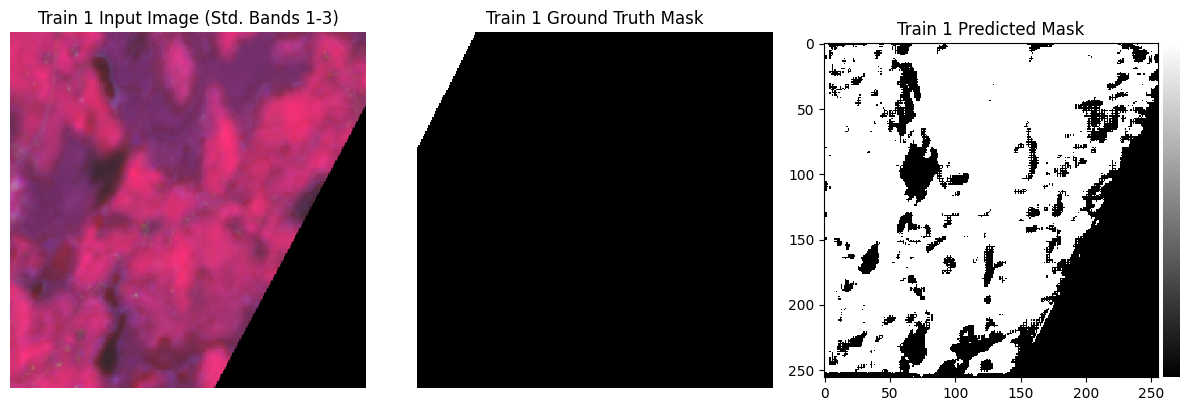

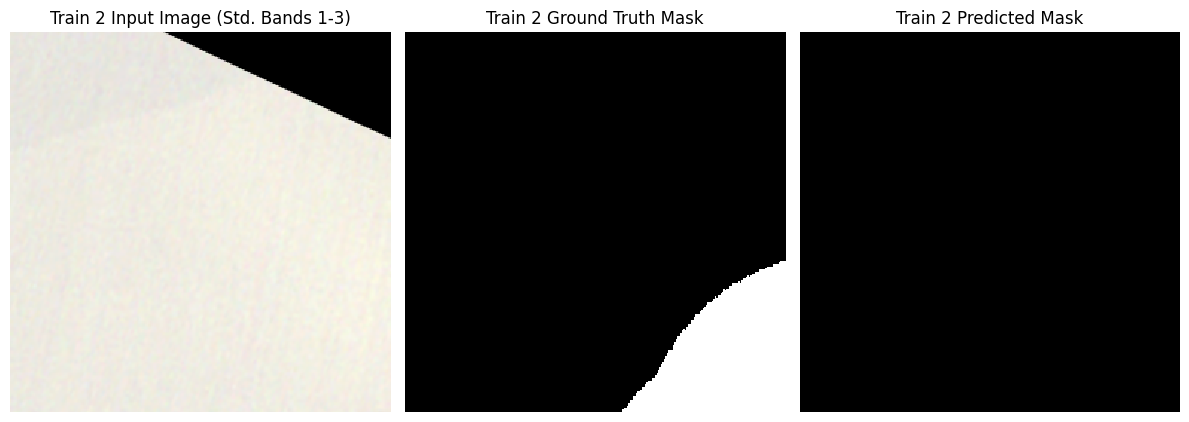

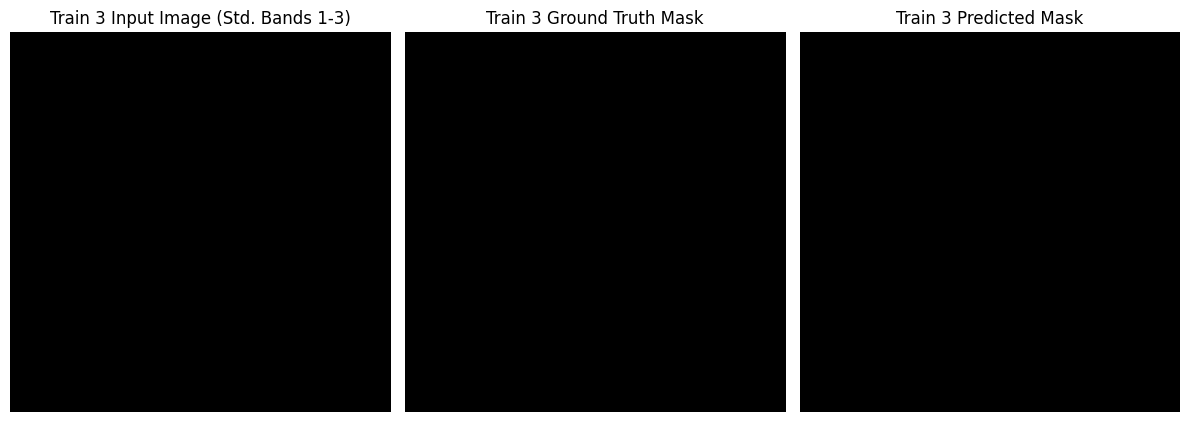

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

--- Validation Examples ---


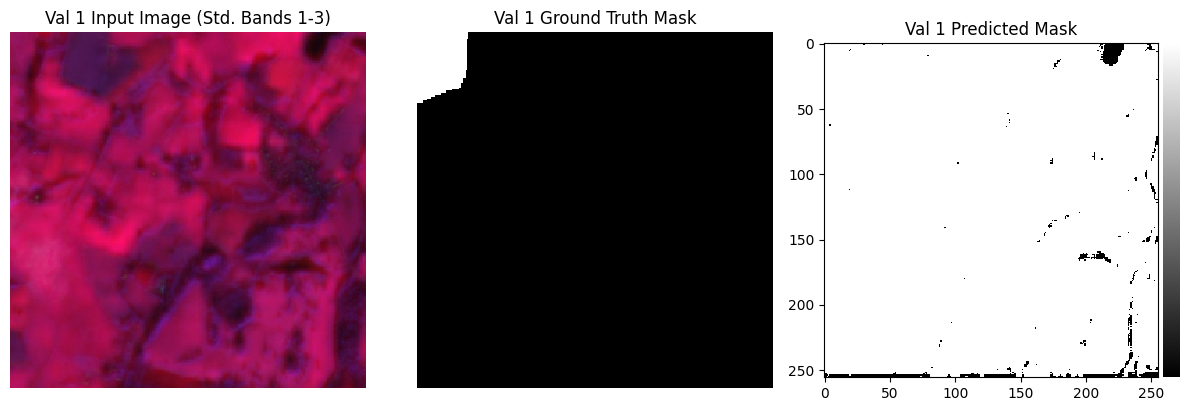

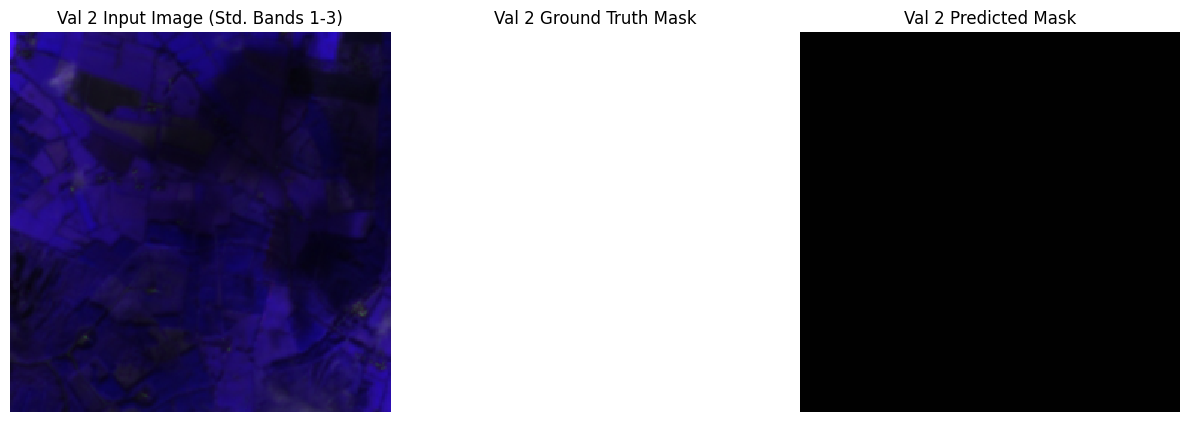

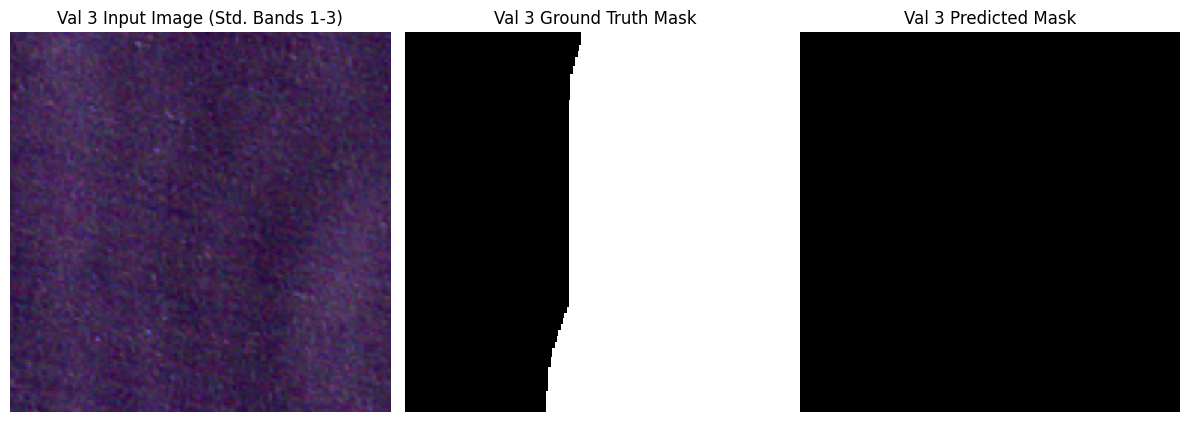

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

--- Test Examples ---


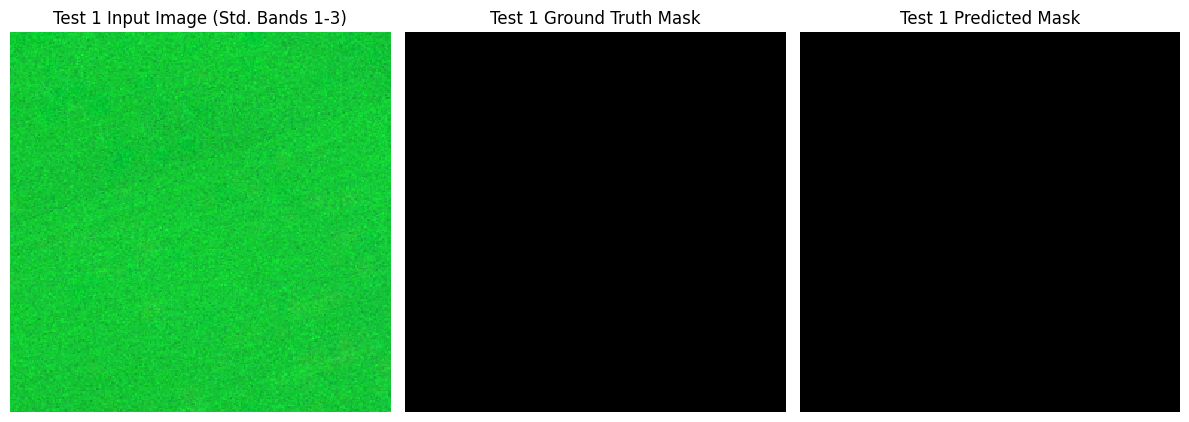

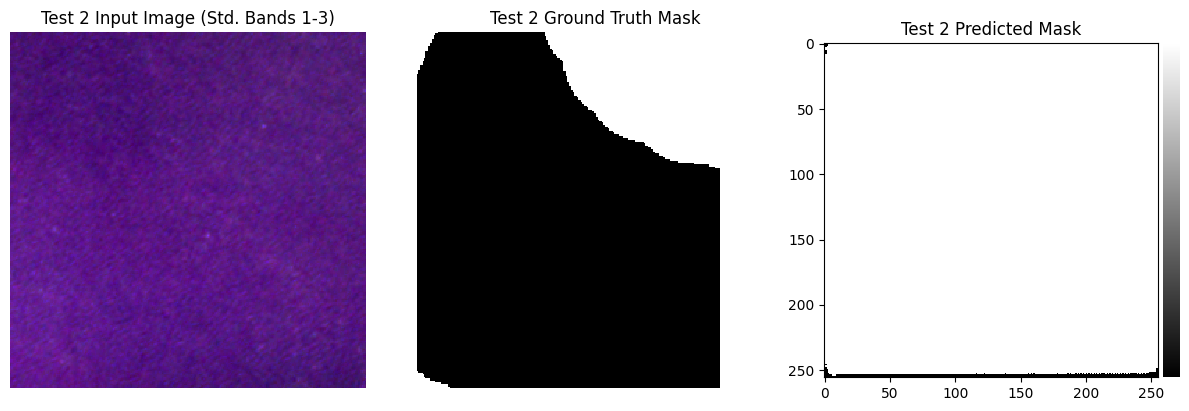

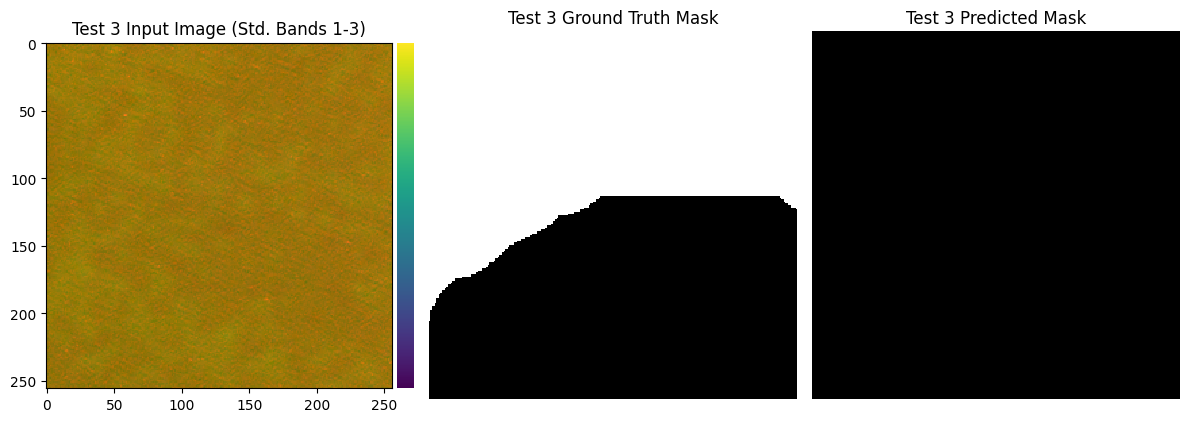


Visualization Script Finished.


In [8]:
# -*- coding: utf-8 -*-
"""
Part 3: Visualization Script for U-Net Coastline Segmentation
Loads the best saved model, predicts on samples, and displays results.
"""

# --- Imports ---
import tensorflow as tf
import numpy as np
import random
import os
import glob
from tqdm.notebook import tqdm
import rasterio
import math
import matplotlib.pyplot as plt
from skimage.io import imshow # For visualization
import warnings

warnings.filterwarnings('ignore')

# --- Configuration (Should match train.py) ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

BASE_DATA_PATH = '/kaggle/input/sentinel-2-wasirq/Data-Set-Unet/'
TRAIN_PATH = os.path.join(BASE_DATA_PATH, 'train/')
VAL_PATH = os.path.join(BASE_DATA_PATH, 'val/')
TEST_PATH = os.path.join(BASE_DATA_PATH, 'test/')

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 12
BATCH_SIZE = 8 # Batch size for prediction

# --- Model Path ---
MODEL_CHECKPOINT_PATH = '/kaggle/input/keras-model/keras/default/1/coastline_unet_model_s2_256_adapt.keras'

# --- Number of Samples to Visualize ---
NUM_VIS_SAMPLES = 3

# --- Data Loading Functions (Copied from train.py) ---
def get_file_paths(data_dir):
    images_path = os.path.join(data_dir, 'images/')
    masks_path = os.path.join(data_dir, 'masks/')
    image_files = sorted(glob.glob(os.path.join(images_path, '*.jp2')))
    mask_files = sorted(glob.glob(os.path.join(masks_path, '*.png')))
    if len(image_files) != len(mask_files):
        print(f"Warning: Mismatch! Found {len(image_files)} images and {len(mask_files)} masks in {data_dir}")
        min_len = min(len(image_files), len(mask_files))
        if min_len == 0: return None, None
        print(f"Attempting to proceed with {min_len} matched pairs.")
        image_files, mask_files = image_files[:min_len], mask_files[:min_len]
    if not image_files or not mask_files: return None, None
    return image_files, mask_files

@tf.function
def parse_image_mask(img_path, mask_path):
    def read_jp2(path):
        path = path.numpy().decode('utf-8')
        try:
            with rasterio.open(path) as img_ds:
                if img_ds.count != IMG_CHANNELS: return np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
                img = img_ds.read().astype(np.float32).transpose((1, 2, 0))
                if img.shape[0] != IMG_HEIGHT or img.shape[1] != IMG_WIDTH:
                     img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR).numpy()
                return img
        except Exception: return np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    img = tf.py_function(read_jp2, [img_path], tf.float32); img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    mask = tf.io.read_file(mask_path); mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32); mask = tf.cast(mask > 127.0, tf.float32)
    return img, mask

def create_tf_dataset(image_files, mask_files, batch_size): # No shuffle needed for viz samples
    if image_files is None or mask_files is None: return None
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size) # Batch is still useful for prediction
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# --- Define Custom Metric for Loading ---
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_pos = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_pos, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred_pos, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean(tf.where(union > 0, (intersection + smooth) / (union + smooth), 1.0))
    return iou

# --- Load the Trained Model ---
print(f"Loading trained model from: {MODEL_CHECKPOINT_PATH}")
if not os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Error: Model file not found at {MODEL_CHECKPOINT_PATH}. Cannot visualize. Run training first.")
else:
    custom_objects = {'iou_metric': iou_metric}
    try:
        model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH, custom_objects=custom_objects)
        print("Model loaded successfully.")

        # --- Prepare Datasets for Visualization Samples ---
        print("Getting sample file paths...")
        train_img_files_vis, train_mask_files_vis = get_file_paths(TRAIN_PATH)
        val_img_files_vis, val_mask_files_vis = get_file_paths(VAL_PATH)
        test_img_files_vis, test_mask_files_vis = get_file_paths(TEST_PATH)

        # Randomly select indices if datasets exist
        train_indices = random.sample(range(len(train_img_files_vis)), min(NUM_VIS_SAMPLES, len(train_img_files_vis))) if train_img_files_vis else []
        val_indices = random.sample(range(len(val_img_files_vis)), min(NUM_VIS_SAMPLES, len(val_img_files_vis))) if val_img_files_vis else []
        test_indices = random.sample(range(len(test_img_files_vis)), min(NUM_VIS_SAMPLES, len(test_img_files_vis))) if test_img_files_vis else []

        # Create small datasets just for these samples
        vis_train_dataset = create_tf_dataset([train_img_files_vis[i] for i in train_indices], [train_mask_files_vis[i] for i in train_indices], BATCH_SIZE) if train_indices else None
        vis_val_dataset = create_tf_dataset([val_img_files_vis[i] for i in val_indices], [val_mask_files_vis[i] for i in val_indices], BATCH_SIZE) if val_indices else None
        vis_test_dataset = create_tf_dataset([test_img_files_vis[i] for i in test_indices], [test_mask_files_vis[i] for i in test_indices], BATCH_SIZE) if test_indices else None

        # --- Function to get samples from tf.data.Dataset ---
        def get_samples_from_dataset(dataset, num_samples):
            images, masks = [], []
            if dataset is None: return images, masks
            count = 0
            for img_batch, mask_batch in dataset.take(math.ceil(num_samples / BATCH_SIZE)):
                for i in range(img_batch.shape[0]):
                     if count < num_samples:
                         images.append(img_batch[i].numpy())
                         masks.append(mask_batch[i].numpy())
                         count += 1
                     else: break
                if count >= num_samples: break
            return images, masks

        # --- Visualization Function ---
        def display_results(image, true_mask, predicted_mask, title_prefix=""):
            true_mask_squeezed = np.squeeze(true_mask)
            predicted_mask_squeezed = np.squeeze(predicted_mask)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 3, 1)
            plt.title(f"{title_prefix} Input Image (Std. Bands 1-3)")
            display_img = image[:, :, :3] # Standardized!
            display_img_min, display_img_max = np.min(display_img), np.max(display_img)
            display_img_scaled = (display_img - display_img_min) / (display_img_max - display_img_min + 1e-6) if display_img_max > display_img_min else np.zeros_like(display_img)
            imshow(np.clip(display_img_scaled, 0, 1))
            plt.axis('off')
            plt.subplot(1, 3, 2); plt.title(f"{title_prefix} Ground Truth Mask"); imshow(true_mask_squeezed, cmap='gray'); plt.axis('off')
            plt.subplot(1, 3, 3); plt.title(f"{title_prefix} Predicted Mask"); imshow(predicted_mask_squeezed, cmap='gray'); plt.axis('off')
            plt.tight_layout(); plt.show()

        # --- Predict and Display ---
        print("\nPredicting and Visualizing Results...")

        # Training samples
        if vis_train_dataset:
            train_images_vis, train_masks_vis = get_samples_from_dataset(vis_train_dataset, NUM_VIS_SAMPLES)
            if train_images_vis:
                preds_train_vis_t = (model.predict(np.array(train_images_vis), batch_size=BATCH_SIZE) > 0.5).astype(np.uint8)
                print("\n--- Training Examples ---")
                for i in range(len(train_images_vis)):
                    display_results(train_images_vis[i], train_masks_vis[i], preds_train_vis_t[i], title_prefix=f"Train {i+1}")
            else: print("\nCould not fetch training samples for visualization.")
        else: print("\nSkipping Training visualization (no samples found).")

        # Validation samples
        if vis_val_dataset:
            val_images_vis, val_masks_vis = get_samples_from_dataset(vis_val_dataset, NUM_VIS_SAMPLES)
            if val_images_vis:
                preds_val_vis_t = (model.predict(np.array(val_images_vis), batch_size=BATCH_SIZE) > 0.5).astype(np.uint8)
                print("\n--- Validation Examples ---")
                for i in range(len(val_images_vis)):
                    display_results(val_images_vis[i], val_masks_vis[i], preds_val_vis_t[i], title_prefix=f"Val {i+1}")
            else: print("\nCould not fetch validation samples for visualization.")
        else: print("\nSkipping Validation visualization (no samples found).")

        # Test samples
        if vis_test_dataset:
            test_images_vis, test_masks_vis = get_samples_from_dataset(vis_test_dataset, NUM_VIS_SAMPLES)
            if test_images_vis:
                preds_test_vis_t = (model.predict(np.array(test_images_vis), batch_size=BATCH_SIZE) > 0.5).astype(np.uint8)
                print("\n--- Test Examples ---")
                for i in range(len(test_images_vis)):
                    display_results(test_images_vis[i], test_masks_vis[i], preds_test_vis_t[i], title_prefix=f"Test {i+1}")
            else: print("\nCould not fetch test samples for visualization.")
        else: print("\nSkipping Test visualization (no samples found).")

    except Exception as e:
        print(f"\nError loading model or predicting: {e}")

print("\nVisualization Script Finished.")